In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import torch
import torch.nn.functional as F
from nltk.tokenize import sent_tokenize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_sentence_embedding(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Mean pooling - take attention mask into account for correct averaging
    token_embeddings = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]
    attention_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

    sum_embeddings = torch.sum(token_embeddings * attention_mask_expanded, dim=1)
    sum_mask = torch.clamp(attention_mask_expanded.sum(dim=1), min=1e-9)  # Avoid division by zero
    mean_pooled = sum_embeddings / sum_mask

    return mean_pooled

def get_most_similar_sentence(question, context, tokenizer, model, similarity_threshold=0.5):
    # Compute embedding for the question
    question_embeddings = get_sentence_embedding(question, tokenizer, model)
    question_embeddings = F.normalize(question_embeddings, p=2, dim=1)  # Normalize embeddings

    # Split the context into sentences
    sentences = sent_tokenize(context)

    # Compute embeddings and cosine similarity for each sentence
    sentence_cosine_scores = []
    for sentence in sentences:
        sent_embeddings = get_sentence_embedding(sentence, tokenizer, model)
        sent_embeddings = F.normalize(sent_embeddings, p=2, dim=1)  # Normalize embeddings
        cosine_scores = F.cosine_similarity(question_embeddings, sent_embeddings).item()
        sentence_cosine_scores.append((cosine_scores, sentence))

    # Get the most similar sentence based on cosine similarity scores
    most_similar_sentence = max(sentence_cosine_scores, key=lambda x: x[0])

    # # Filter out sentences below similarity threshold
    # if most_similar_sentence[0] < similarity_threshold or len(most_similar_sentence[1]) < 30:
    #     return ('', 0)

    return most_similar_sentence[1], most_similar_sentence[0]


In [ ]:
question = 'Car Racing is popular in countries like India where people generally support adventures'
# Give me context which has many sentences with few words in each sentence
# sample_context = 'I am Naveen I work for IIIT. I have data science degree. I know a lot of tech'
import nltk
nltk.download('punkt')
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

context = 'Healthcare policies in European countries focus on providing universal access to medical services for all citizens'
from transformers import AutoTokenizer, AutoModel
models = [
    "dmis-lab/biobert-base-cased-v1.1",                        # BioBERT
    "emilyalsentzer/Bio_ClinicalBERT",                          # Clinical BERT
    "emilyalsentzer/Bio_Discharge_Summary_BERT",                # Discharge Summary BERT
    "google-bert/bert-large-uncased-whole-word-masking",        # BERT Large
    "google-bert/bert-base-uncased",                            # BERT Base
]
for model_name in models:
  print(f"Processing with model: {model_name}")
  # Load model and tokenizer
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModel.from_pretrained(model_name).to(device)
  # model_name = models[0]
  # Load model and tokenizer
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModel.from_pretrained(model_name).to(device)

  print(get_most_similar_sentence(question, context, tokenizer, model))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Processing with model: dmis-lab/biobert-base-cased-v1.1
('Healthcare policies in European countries focus on providing universal access to medical services for all citizens', 0.8704408407211304)
Processing with model: emilyalsentzer/Bio_ClinicalBERT
('Healthcare policies in European countries focus on providing universal access to medical services for all citizens', 0.8612293004989624)
Processing with model: emilyalsentzer/Bio_Discharge_Summary_BERT
('Healthcare policies in European countries focus on providing universal access to medical services for all citizens', 0.87739098072052)
Processing with model: google-bert/bert-large-uncased-whole-word-masking
('Healthcare policies in European countries focus on providing universal access to medical services for all citizens', 0.7181842923164368)
Processing with model: google-bert/bert-base-uncased
('Healthcare policies in European countries focus on providing universal access to medical services for all citizens', 0.617878258228302)


In [ ]:
# !pip install sentence_transformers
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Compute embeddings for both sentences
embedding1 = model.encode("Car Racing is popular in countries like India where people generally support adventures.")
embedding2 = model.encode("Motorsports, especially car racing, are well-loved in nations such as India, where there is a strong enthusiasm for thrilling activities.")

# Compute cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity([embedding1], [embedding2])
print(similarity)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[[0.8213086]]


In [ ]:
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

# Load the tokenizer and model for BERT-base and BERT-large
def load_model_and_tokenizer(model_name, device):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name).to(device)  # Move the model to the correct device
    model.eval()  # Set model to evaluation mode
    return tokenizer, model

# Function to get sentence embedding using mean pooling
def get_sentence_embedding(sentence, tokenizer, model, device):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)
    input_ids = inputs['input_ids'].to(device)  # Move input_ids to the same device as the model
    attention_mask = inputs['attention_mask'].to(device)  # Move attention_mask to the same device as the model

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Mean pooling: multiply embeddings by attention mask, sum, and normalize
    token_embeddings = outputs.last_hidden_state
    attention_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

    sum_embeddings = torch.sum(token_embeddings * attention_mask_expanded, dim=1)
    sum_mask = torch.clamp(attention_mask_expanded.sum(dim=1), min=1e-9)  # Avoid division by zero
    mean_pooled = sum_embeddings / sum_mask

    return mean_pooled.cpu()  # Move embedding back to CPU for further processing

# Function to calculate cosine similarity between two sentences
def get_cosine_similarity(sentence1, sentence2, tokenizer, model, device):
    embedding1 = get_sentence_embedding(sentence1, tokenizer, model, device)
    embedding2 = get_sentence_embedding(sentence2, tokenizer, model, device)

    # Compute cosine similarity
    similarity = cosine_similarity(embedding1, embedding2)
    return similarity[0][0]

# Define the sentences
sentence1 = "Car Racing is popular in countries like India where people generally support adventures."
sentence2 = "Healthcare policies in European countries focus on providing universal access to medical services for all citizens."

# Load BERT-base and BERT-large models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# BERT-base-uncased
print("Processing with BERT-base-uncased...")
tokenizer_base, model_base = load_model_and_tokenizer('bert-base-uncased', device)
similarity_base = get_cosine_similarity(sentence1, sentence2, tokenizer_base, model_base, device)
print(f"BERT-base-uncased similarity: {similarity_base}")

# BERT-large-uncased
print("\nProcessing with BERT-large-uncased...")
tokenizer_large, model_large = load_model_and_tokenizer('bert-large-uncased', device)
similarity_large = get_cosine_similarity(sentence1, sentence2, tokenizer_large, model_large, device)
print(f"BERT-large-uncased similarity: {similarity_large}")


Processing with BERT-base-uncased...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


BERT-base-uncased similarity: 0.6500651836395264

Processing with BERT-large-uncased...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


BERT-large-uncased similarity: 0.7637178897857666


In [ ]:
suhi_combined_file_path = '/content/drive/MyDrive/SUHI/Data/CAP_Postdischarge_data_16FEB24.xlsx - coded.csv'
suhi_df = pd.read_csv(suhi_combined_file_path)

<ipython-input-20-b85ddacd002c>:2: DtypeWarning: Columns (100,110,130,147,161,168,173,178,194,198,214,226,254,259,274,276,283,293,297,303,310,366,379,381,384,386,390,392,401,403,406,411,414,417,419,422,424,427,430,433,435,438,444,446,449,451,454,456,459,461,468,472,474,476,480,484,486,489) have mixed types. Specify dtype option on import or set low_memory=False.
  suhi_df = pd.read_csv(suhi_combined_file_path)


In [ ]:
suhi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2620 entries, 0 to 2619
Columns: 492 entries, 7 to old_sdoh_questionnaire_complete
dtypes: float64(264), int64(94), object(134)
memory usage: 9.8+ MB


In [ ]:
for col in suhi_df.columns:
  if col.startswith('notes_contact'):
    print(col)

notes_contact1
notes_contact2
notes_contact3
notes_contact4
notes_contact5
notes_contact6
notes_contact7
notes_contact8
notes_contact9
notes_contact10


In [ ]:
suhi_df['combined_notes'] = suhi_df[suhi_df.columns[suhi_df.columns.str.contains('notes_contact')]].apply(
    lambda x: '. '.join(x.dropna().astype(str).str.lower()), axis=1)

In [ ]:
# Filter the records if len of combined_notes<1
suhi_df = suhi_df[suhi_df['combined_notes'].str.len() > 0]

In [ ]:
suhi_filtered_df = suhi_df[['notes_contact1', 'notes_contact2', 'notes_contact3', 'notes_contact4',
                           'notes_contact5', 'notes_contact6', 'notes_contact7', 'notes_contact8',
                           'notes_contact9', 'notes_contact10', 'combined_notes', 'day_readmit']]

In [ ]:
# Drop based on null values in combined_notes
suhi_filtered_without_null_df = suhi_filtered_df.dropna(subset=['combined_notes', 'day_readmit'])

In [ ]:
suhi_filtered_without_null_df

,notes_contact1,notes_contact2,notes_contact3,notes_contact4,notes_contact5,notes_contact6,notes_contact7,notes_contact8,notes_contact9,notes_contact10,combined_notes,day_readmit
2,declined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,declined,1.0
3,SDOH,NaN,EMOTIONAL SUPPORT,CLOSED CASE,NaN,NaN,NaN,NaN,NaN,NaN,sdoh. emotional support. closed case,0.0
5,DECLINED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,declined,0.0
6,SDOH/ DECLINED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sdoh/ declined,0.0
7,Looking for housing in the same and needs acce...,The pt reached out to me to let me know she is...,NaN,NaN,I spoke with the Pt about where the status of ...,Closed case -,NaN,NaN,NaN,NaN,looking for housing in the same and needs acce...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2574,VM is not set up.,VM is not set up.,"Mailbox is full, unable to LVM.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,vm is not set up.. vm is not set up.. mailbox ...,1.0
2575,Phone rang for a while and went to a busy sign...,"Not a working number, number same as Epic.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,phone rang for a while and went to a busy sign...,0.0
2577,I reached out to the pt two consecutive times ...,I reached out to the pt but received no respon...,I reached out to the pt but received no respon...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,i reached out to the pt two consecutive times ...,0.0
2589,Both phone numbers for patient is not in servi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both phone numbers for patient is not in servi...,0.0


In [ ]:
import pandas as pd
import re

def remove_repeated_chars(text):
    return re.sub(r'(.)\1{2,}', '', str(text))

suhi_filtered_without_null_df['combined_notes'] = suhi_filtered_without_null_df['combined_notes'].apply(remove_repeated_chars)

<ipython-input-47-9d6f5751125c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suhi_filtered_without_null_df['combined_notes'] = suhi_filtered_without_null_df['combined_notes'].apply(remove_repeated_chars)


In [ ]:
context_len_list = []
context_word_count_list = []
for combined_notes in suhi_filtered_without_null_df['combined_notes']:
  context_len_list.append(len(combined_notes))
  context_word_count_list.append(len(combined_notes.split()))

In [ ]:
# Calculate the five-number summary
print('Five number summary of length of combined notes')
minimum = np.min(context_len_list)
first_quartile = np.percentile(context_len_list, 25)
median = np.median(context_len_list)
third_quartile = np.percentile(context_len_list, 75)
maximum = np.max(context_len_list)

# Display the results
print("Minimum:", minimum)
print("First Quartile (Q1):", first_quartile)
print("Median:", median)
print("Third Quartile (Q3):", third_quartile)
print("Maximum:", maximum)


Five number summary of length of combined notes
Minimum: 2
First Quartile (Q1): 108.75
Median: 310.5
Third Quartile (Q3): 652.25
Maximum: 4156


In [ ]:
# Calculate the five-number summary
print('Five number summary of word count of combined notes')
minimum = np.min(context_word_count_list)
first_quartile = np.percentile(context_word_count_list, 25)
median = np.median(context_word_count_list)
third_quartile = np.percentile(context_word_count_list, 75)
maximum = np.max(context_word_count_list)

# Display the results
print("Minimum:", minimum)
print("First Quartile (Q1):", first_quartile)
print("Median:", median)
print("Third Quartile (Q3):", third_quartile)
print("Maximum:", maximum)


Five number summary of word count of combined notes
Minimum: 1
First Quartile (Q1): 20.0
Median: 58.0
Third Quartile (Q3): 120.0
Maximum: 791


In [ ]:
# Replacing short forms in each record
for record in range(len(suhi_filtered_without_null_df['combined_notes'])):
  if 'sdoh' in suhi_filtered_without_null_df['combined_notes'][record]:
    suhi_filtered_without_null_df['combined_notes'][record] = suhi_filtered_without_null_df['combined_notes'][record].replace('sdoh ', ' social determinants of health ')
  if 'pt' in suhi_filtered_without_null_df['combined_notes'][record]:
    suhi_filtered_without_null_df['combined_notes'][record] = suhi_filtered_without_null_df['combined_notes'][record].replace('pt ', ' patient ')
  if "pt's" in suhi_filtered_without_null_df['combined_notes'][record]:
    suhi_filtered_without_null_df['combined_notes'][record] = suhi_filtered_without_null_df['combined_notes'][record].replace("pt's ", ' patients ')
  if 'pcp' in suhi_filtered_without_null_df['combined_notes'][record]:
    suhi_filtered_without_null_df['combined_notes'][record] = suhi_filtered_without_null_df['combined_notes'][record].replace('pcp ', ' primary care provider ')
  if 'lvm' in suhi_filtered_without_null_df['combined_notes'][record]:
    suhi_filtered_without_null_df['combined_notes'][record] = suhi_filtered_without_null_df['combined_notes'][record].replace('lvm ', ' left voice mail ')

Streaming output truncated to the last 5000 lines.
<ipython-input-56-9a5b111d8cb8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suhi_filtered_without_null_df['combined_notes'][record] = suhi_filtered_without_null_df['combined_notes'][record].replace(' pt ', ' patient ')
<ipython-input-56-9a5b111d8cb8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suhi_filtered_without_null_df['combined_notes'][record] = suhi_filtered_without_null_df['combined_notes'][record].replace(' pt ', ' patient ')
<ipython-input-56-9a5b111d8cb8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame



In [ ]:
for i in suhi_filtered_without_null_df['combined_notes']:
  print(50*'*')
  print(i)

**************************************************
declined
**************************************************
sdoh. emotional support. closed case
**************************************************
declined
**************************************************
sdoh/ declined
**************************************************
looking for housing in the same and needs access to an elevator for her powered wheelchair.. the patient reached out to me to let me know she is currently back in the hospital. i reassured her that i'm looking for housing for her. i spoke with the patient about where the status of her  cha application.. closed case -
**************************************************
sdoh/ emotional support. emotiional support/ case cloud
**************************************************
declined completed sdoh
**************************************************
check to see if primary care provider has returned and visit is made.. appointment has been set for pcp.
******************

In [ ]:
complete_notes = ''
for note in suhi_filtered_without_null_df['combined_notes']:
  complete_notes += note

In [ ]:
def word_frequency(text):
    # Normalize the text to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join(char for char in text if char.isalnum() or char.isspace())
    # Split the text into words
    words = text.split()
    # Calculate frequency
    frequency = {}
    for word in words:
        if word in frequency:
            frequency[word] += 1
        else:
            frequency[word] = 1
    return frequency
result = word_frequency(complete_notes)
print(result)

{'declinedsdoh': 1, 'emotional': 21, 'support': 99, 'closed': 114, 'casedeclinedsdoh': 1, 'declinedlooking': 1, 'for': 1342, 'housing': 46, 'in': 1165, 'the': 4142, 'same': 32, 'and': 3282, 'needs': 626, 'access': 49, 'to': 5298, 'an': 353, 'elevator': 2, 'her': 1812, 'powered': 1, 'wheelchair': 17, 'patient': 6458, 'reached': 398, 'out': 736, 'me': 1137, 'let': 177, 'know': 274, 'she': 2951, 'is': 1776, 'currently': 116, 'back': 693, 'hospital': 211, 'i': 5318, 'reassured': 2, 'that': 1962, 'im': 46, 'looking': 14, 'spoke': 730, 'with': 2540, 'about': 166, 'where': 58, 'status': 35, 'of': 850, 'cha': 7, 'application': 65, 'case': 575, 'sdoh': 48, 'emotiional': 1, 'clouddeclined': 1, 'completed': 49, 'sdohcheck': 1, 'see': 183, 'if': 803, 'primary': 245, 'care': 361, 'provider': 256, 'has': 953, 'returned': 22, 'visit': 41, 'made': 74, 'appointment': 219, 'been': 321, 'set': 61, 'pcppt': 1, 'stated': 2738, 'ok': 194, 'doesnt': 191, 'need': 350, 'any': 416, 'assistancehas': 1, 'pcpjobsp

In [ ]:
sorted_word_counts = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))

# Step 2: Select the top 20 words from the sorted dictionary
top_20_words = {k: sorted_word_counts[k] for k in list(sorted_word_counts)[:20]}
top_20_words

{'patient': 6458,
 'i': 5318,
 'to': 5298,
 'the': 4142,
 'and': 3282,
 'she': 2951,
 'stated': 2738,
 'he': 2666,
 'with': 2540,
 'that': 1962,
 'was': 1931,
 'her': 1812,
 'is': 1776,
 'will': 1690,
 'a': 1558,
 'called': 1371,
 'for': 1342,
 'call': 1232,
 'in': 1165,
 'me': 1137}

In [ ]:
# Reset the index
suhi_filtered_without_null_df.reset_index(drop=True, inplace=True)

In [ ]:
suhi_filtered_without_null_df

,notes_contact1,notes_contact2,notes_contact3,notes_contact4,notes_contact5,notes_contact6,notes_contact7,notes_contact8,notes_contact9,notes_contact10,combined_notes,day_readmit
0,declined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,declined,1.0
1,SDOH,NaN,EMOTIONAL SUPPORT,CLOSED CASE,NaN,NaN,NaN,NaN,NaN,NaN,sdoh. emotional support. closed case,0.0
2,DECLINED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,declined,0.0
3,SDOH/ DECLINED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sdoh/ declined,0.0
4,Looking for housing in the same and needs acce...,The pt reached out to me to let me know she is...,NaN,NaN,I spoke with the Pt about where the status of ...,Closed case -,NaN,NaN,NaN,NaN,looking for housing in the same and needs acce...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1471,VM is not set up.,VM is not set up.,"Mailbox is full, unable to LVM.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,vm is not set up.. vm is not set up.. mailbox ...,1.0
1472,Phone rang for a while and went to a busy sign...,"Not a working number, number same as Epic.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,phone rang for a while and went to a busy sign...,0.0
1473,I reached out to the pt two consecutive times ...,I reached out to the pt but received no respon...,I reached out to the pt but received no respon...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,i reached out to the patient two consecutive t...,0.0
1474,Both phone numbers for patient is not in servi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both phone numbers for patient is not in servi...,0.0


In [ ]:
models = [
    "dmis-lab/biobert-base-cased-v1.1",                        # BioBERT
    # "emilyalsentzer/Bio_ClinicalBERT",                          # Clinical BERT
    # "emilyalsentzer/Bio_Discharge_Summary_BERT",                # Discharge Summary BERT
    # "google-bert/bert-large-uncased-whole-word-masking",        # BERT Large
    # "google-bert/bert-base-uncased",                            # BERT Base
]

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def get_sentence_embedding(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Extract the CLS token embedding from the last hidden state layer
    cls_embedding = outputs.last_hidden_state[:, 0]

    return cls_embedding

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import sent_tokenize

def get_most_similar_sentence(question, context, tokenizer, model):
    # Compute embedding for the question
    question_embeddings = get_sentence_embedding(question, tokenizer, model)
    try:
      # Split the context into sentences
      sentences = sent_tokenize(context)

      # Compute embeddings and cosine similarity for each sentence
      sentence_cosine_scores = []
      for sentence in sentences:
          sent_embeddings = get_sentence_embedding(sentence, tokenizer, model)
          cosine_scores = cosine_similarity(question_embeddings.cpu().numpy(), sent_embeddings.cpu().numpy())
          sentence_cosine_scores.append((cosine_scores[0][0], sentence))
      # Get the most similar sentence based on cosine similarity scores
      most_similar_sentence = max(sentence_cosine_scores, key=lambda x: x[0])
      # Filter the sentences with records lesser than 30 characters
      if len(most_similar_sentence[1]) < 30:
        return ('', 0)
    except Exception as e:
      print(e)
      print(context)
      return ('', 0)

    return most_similar_sentence[1], max(sentence_cosine_scores)[0]

In [ ]:
Topics = ['Social determinants of health', 'Food insecurity',
          'Primary care physician', 'Bill Payment Assistance',
          'Social Worker', 'Community health worker', 'referral',
          'Insurance', 'Unmet Needs', 'Comorbidities', 'Unemployment',
          'Transportation', 'Comorbidity', 'Car Racing', 'Swimming',
          'Operating Systems', 'Deep Learning']

In [ ]:
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import nltk
nltk.download('punkt')

semantic_scores_list = []
for topic in Topics:
  for model_name in models:
    print(f"Processing with model: {model_name}")
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    semantic_topic_scores_list = []
    for i in tqdm(range(len(suhi_filtered_without_null_df))):
        try:
          similar_sentence, similarity_score = get_most_similar_sentence(topic, suhi_filtered_without_null_df['combined_notes'][i], tokenizer, model)
          semantic_topic_scores_list.append((similar_sentence, similarity_score))
        except ValueError:
        # similar_sentence, similarity_score = get_most_similar_sentence(topic, suhi_filtered_without_null_df['combined_notes'][i], tokenizer, model)
          semantic_topic_scores_list.append(())
    semantic_scores_list.append(semantic_topic_scores_list)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Processing with model: dmis-lab/biobert-base-cased-v1.1


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 1476/1476 [01:45<00:00, 14.03it/s]


Processing with model: dmis-lab/biobert-base-cased-v1.1


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 1476/1476 [01:59<00:00, 12.38it/s]


Processing with model: dmis-lab/biobert-base-cased-v1.1


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 1476/1476 [01:48<00:00, 13.62it/s]


Processing with model: dmis-lab/biobert-base-cased-v1.1


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 1476/1476 [01:45<00:00, 14.05it/s]


Processing with model: dmis-lab/biobert-base-cased-v1.1


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 1476/1476 [01:43<00:00, 14.24it/s]


Processing with model: dmis-lab/biobert-base-cased-v1.1


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 1476/1476 [01:42<00:00, 14.36it/s]


Processing with model: dmis-lab/biobert-base-cased-v1.1


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 1476/1476 [01:41<00:00, 14.59it/s]


Processing with model: dmis-lab/biobert-base-cased-v1.1


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 1476/1476 [01:41<00:00, 14.58it/s]


Processing with model: dmis-lab/biobert-base-cased-v1.1


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 1476/1476 [01:40<00:00, 14.66it/s]


Processing with model: dmis-lab/biobert-base-cased-v1.1


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 1476/1476 [01:42<00:00, 14.45it/s]


Processing with model: dmis-lab/biobert-base-cased-v1.1


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 1476/1476 [01:40<00:00, 14.66it/s]


Processing with model: dmis-lab/biobert-base-cased-v1.1


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 1476/1476 [01:40<00:00, 14.63it/s]


Processing with model: dmis-lab/biobert-base-cased-v1.1


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 1476/1476 [01:41<00:00, 14.60it/s]


Processing with model: dmis-lab/biobert-base-cased-v1.1


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 1476/1476 [01:40<00:00, 14.70it/s]


Processing with model: dmis-lab/biobert-base-cased-v1.1


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 1476/1476 [01:44<00:00, 14.15it/s]


Processing with model: dmis-lab/biobert-base-cased-v1.1


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 1476/1476 [01:43<00:00, 14.26it/s]


Processing with model: dmis-lab/biobert-base-cased-v1.1


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 1476/1476 [01:42<00:00, 14.47it/s]


In [ ]:
topic_sentence_lists = {f"{topic} extracted sentence": [] for topic in Topics}
topic_score_lists = {f"{topic} similarity score": [] for topic in Topics}

In [ ]:
for topic_num in range(len(Topics)):
  for i in range(len(semantic_scores_list[topic_num])):
    try:
      topic_sentence_lists[list(topic_sentence_lists.keys())[topic_num]].append(semantic_scores_list[topic_num][i][0])
      topic_score_lists[list(topic_score_lists.keys())[topic_num]].append(semantic_scores_list[topic_num][i][1])
    except:
      topic_sentence_lists[list(topic_sentence_lists.keys())[topic_num]].append('')
      topic_score_lists[list(topic_score_lists.keys())[topic_num]].append('')

In [ ]:
for topic in topic_sentence_lists:
  print(topic, len(topic_sentence_lists[topic]))

Social determinants of health extracted sentence 1476
Food insecurity extracted sentence 1476
Primary care physician extracted sentence 1476
Bill Payment Assistance extracted sentence 1476
Social Worker extracted sentence 1476
Community health worker extracted sentence 1476
referral extracted sentence 1476
Insurance extracted sentence 1476
Unmet Needs extracted sentence 1476
Comorbidities extracted sentence 1476
Unemployment extracted sentence 1476
Transportation extracted sentence 1476
Comorbidity extracted sentence 1476
Car Racing extracted sentence 1476
Swimming extracted sentence 1476
Operating Systems extracted sentence 1476
Deep Learning extracted sentence 1476


In [ ]:
topic_sentence_df = pd.DataFrame(topic_sentence_lists)
topic_score_df = pd.DataFrame(topic_score_lists)

In [ ]:
topic_sentence_df = pd.DataFrame(topic_sentence_lists)
topic_score_df = pd.DataFrame(topic_score_lists)
# Merge multiple dataframes
suhi_filtered_without_null_with_extraction_df = pd.concat([suhi_filtered_without_null_df, topic_sentence_df, topic_score_df], axis=1)

In [ ]:
suhi_filtered_without_null_with_extraction_df.to_csv('/content/drive/MyDrive/SUHI/Results/suhi_filtered_without_null_with_bio_bert_cls_extraction_v2.csv', index=False)

In [ ]:
suhi_filtered_without_null_with_extraction_df = pd.read_csv('/content/drive/MyDrive/SUHI/Results/suhi_filtered_without_null_with_bio_bert_cls_extraction_v2.csv')

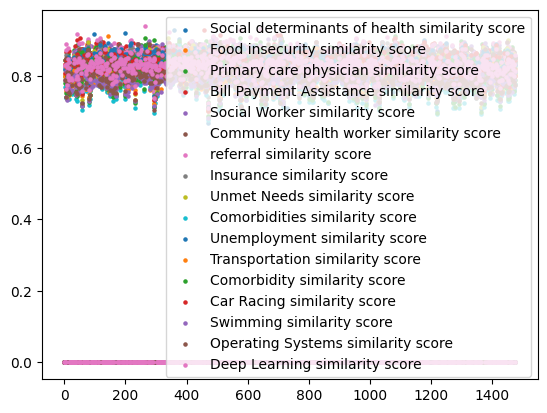

In [ ]:
for column in suhi_filtered_without_null_with_extraction_df.select_dtypes(include=[np.number]).columns:
    if 'similarity score' in column:
        plt.scatter(suhi_filtered_without_null_with_extraction_df.index, suhi_filtered_without_null_with_extraction_df[column], label=column, alpha=1.0, s=5)
plt.legend(loc='best')
plt.show()

In [ ]:
statements = [
    "The social determinants of health (SDH) are the non-medical factors that influence health outcomes. They are the conditions in which people are born, grow, work, live, and age, and the wider set of forces and systems shaping the conditions of daily life.",
    "Access to affordable, healthy food options is an important social determinant of health that can impact a person's overall wellbeing.",
    "Primary care physicians play a crucial role in addressing social determinants of health in clinical settings, though they may sometimes lack confidence in addressing patients' social needs.",
    "Many hospitals offer financial assistance programs, sometimes called 'charity care,' which provide free or discounted health care to people who need help paying their medical bills.",
    "In primary healthcare settings, social workers deliver or support the delivery of mental healthcare, but their role extends beyond that domain to encompass a broader set of services that contribute to the individual's health and wellbeing.",
    "Community health workers form the backbone of Partners In Health, providing home visits, helping patients access medication and essential resources, and advocating for patients in the healthcare system.",
    "Social workers in healthcare help to address financial stress by referring patients to community resources, financial assistance plans and legal aid as needed."
]

In [ ]:
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
semantic_scores_list = []
for statement in statements:
  for model_name in models:
    print(f"Processing with model: {model_name}")
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    semantic_statement_scores_list = []
    for i in tqdm(range(len(suhi_filtered_without_null_df))):
        try:
          similar_sentence, similarity_score = get_most_similar_sentence(statement, suhi_filtered_without_null_df['combined_notes'][i], tokenizer, model)
          semantic_statement_scores_list.append((similar_sentence, similarity_score))
        except ValueError:
        # similar_sentence, similarity_score = get_most_similar_sentence(statement, suhi_filtered_without_null_df['combined_notes'][i], tokenizer, model)
          semantic_statement_scores_list.append(())
    semantic_scores_list.append(semantic_statement_scores_list)

Processing with model: google-bert/bert-large-uncased-whole-word-masking


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 618/618 [01:21<00:00,  7.59it/s]


Processing with model: google-bert/bert-large-uncased-whole-word-masking


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 618/618 [01:21<00:00,  7.62it/s]


Processing with model: google-bert/bert-large-uncased-whole-word-masking


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 618/618 [01:22<00:00,  7.46it/s]


Processing with model: google-bert/bert-large-uncased-whole-word-masking


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 618/618 [01:22<00:00,  7.51it/s]


Processing with model: google-bert/bert-large-uncased-whole-word-masking


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 618/618 [01:22<00:00,  7.52it/s]


Processing with model: google-bert/bert-large-uncased-whole-word-masking


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 618/618 [01:20<00:00,  7.66it/s]


Processing with model: google-bert/bert-large-uncased-whole-word-masking


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 618/618 [01:20<00:00,  7.64it/s]


In [ ]:
statement_sentence_lists = {f"{statement} extracted sentence": [] for statement in Topics}
statement_score_lists = {f"{statement} similarity score": [] for statement in Topics}
for statement_num in range(len(statements)):
  for i in range(len(semantic_scores_list[statement_num])):
    try:
      statement_sentence_lists[list(statement_sentence_lists.keys())[statement_num]].append(semantic_scores_list[statement_num][i][0])
      statement_score_lists[list(statement_score_lists.keys())[statement_num]].append(semantic_scores_list[statement_num][i][1])
    except:
      statement_sentence_lists[list(statement_sentence_lists.keys())[statement_num]].append('')
      statement_score_lists[list(statement_score_lists.keys())[statement_num]].append('')

In [ ]:
for statement in statement_sentence_lists:
  print(statement, len(statement_sentence_lists[statement]))

SODH: social determinants of health extracted sentence 618
Food insecurity extracted sentence 618
PCP: primary care physician extracted sentence 618
Bill Payment Assistance extracted sentence 618
Social Worker extracted sentence 618
Community health worker extracted sentence 618
referral extracted sentence 618


In [ ]:
statement_sentence_df = pd.DataFrame(statement_sentence_lists)
statement_score_df = pd.DataFrame(statement_score_lists)
# Merge multiple dataframes
suhi_filtered_without_null_with_extraction_statement_df = pd.concat([suhi_filtered_without_null_df, statement_sentence_df, statement_score_df], axis=1)

In [ ]:
suhi_filtered_without_null_with_extraction_statement_df.to_csv('/content/drive/MyDrive/SUHI/Results/suhi_filtered_without_null_with_bert_large_extraction_statement.csv', index=False)

In [ ]:
suhi_filtered_without_null_with_extraction_statement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Data columns (total 25 columns):
 #   Column                                                  Non-Null Count  Dtype 
---  ------                                                  --------------  ----- 
 0   notes_contact1                                          438 non-null    object
 1   notes_contact2                                          328 non-null    object
 2   notes_contact3                                          286 non-null    object
 3   notes_contact4                                          160 non-null    object
 4   notes_contact5                                          121 non-null    object
 5   notes_contact6                                          75 non-null     object
 6   notes_contact7                                          50 non-null     object
 7   notes_contact8                                          33 non-null     object
 8   notes_contact9                                    

In [ ]:
suhi_filtered_without_null_with_extraction_statement_df = pd.read_csv('/content/drive/MyDrive/SUHI/Results/suhi_filtered_without_null_with_bert_large_extraction_statement.csv')

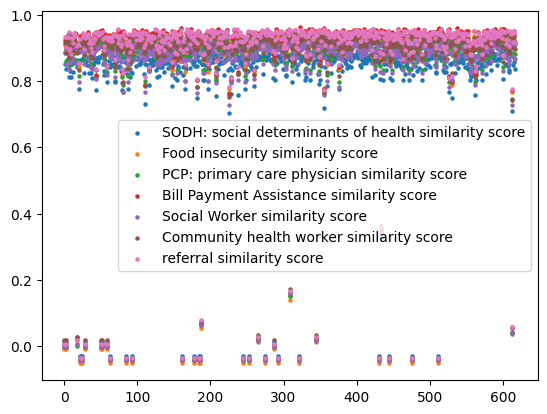

In [ ]:
for column in suhi_filtered_without_null_with_extraction_statement_df.columns:
  if 'similarity score' in column:
      plt.scatter(suhi_filtered_without_null_with_extraction_statement_df.index, suhi_filtered_without_null_with_extraction_statement_df[column], label=column, alpha=1.0, s=5)
plt.legend(loc='best')
plt.show()

In [ ]:
suhi_filtered_without_null_with_extraction_statement_df

,notes_contact1,notes_contact2,notes_contact3,notes_contact4,notes_contact5,notes_contact6,notes_contact7,notes_contact8,notes_contact9,notes_contact10,...,Social Worker extracted sentence,Community health worker extracted sentence,referral extracted sentence,SODH: social determinants of health similarity score,Food insecurity similarity score,PCP: primary care physician similarity score,Bill Payment Assistance similarity score,Social Worker similarity score,Community health worker similarity score,referral similarity score
0,declined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,declined,declined,declined,0.05909,0.069074,0.073206,0.04777,0.062357,0.110162,0.136776
1,SDOH,NaN,EMOTIONAL SUPPORT,CLOSED CASE,NaN,NaN,NaN,NaN,NaN,NaN,...,sdoh emotional support closed case,sdoh emotional support closed case,sdoh emotional support closed case,0.796072,0.78662,0.794144,0.813346,0.803873,0.857125,0.869785
2,DECLINED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,declined,declined,declined,0.05909,0.069074,0.073206,0.04777,0.062357,0.110162,0.136776
3,SDOH/ DECLINED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,sdoh/ declined,sdoh/ declined,sdoh/ declined,0.788738,0.803716,0.783303,0.769201,0.773246,0.803081,0.816177
4,Looking for housing in the same and needs acce...,The pt reached out to me to let me know she is...,NaN,NaN,I spoke with the Pt about where the status of ...,Closed case -,NaN,NaN,NaN,NaN,...,thepatientreached out to me to let me know she...,looking for housing in the same and needs acce...,looking for housing in the same and needs acce...,0.798369,0.807145,0.793248,0.818098,0.801118,0.830729,0.850151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,"wrong #, no working number on file","also wrong #, no working number on file",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"wrong #, no working number on file also wrong ...","wrong #, no working number on file also wrong ...","wrong #, no working number on file also wrong ...",0.717554,0.707703,0.694961,0.735968,0.710089,0.734882,0.763366
614,NaN,Spoke with someone else and was given another ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,spoke with someone else and was given another ...,spoke with someone else and was given another ...,spoke with someone else and was given another ...,0.775309,0.781507,0.770372,0.764967,0.761087,0.801913,0.822556
615,I spoke with this pleasant young lady who stat...,I spoke with pt who stated she is doing well. ...,"Called pt, no answer, unable to LVM.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,she helps to support her parents,she helps to support her parents,she helps to support her parents,0.814207,0.843807,0.82888,0.852601,0.820738,0.875057,0.899158
616,"I spoke with pt who stated that he is in pain,...","I spoke with pt's niece, XXXXX, who stated tha...",Called pt to inform him the steps he needs to ...,"I called pt, and I spoke with pt's niece, who ...","I called pt, no answer. I left a voice message...",I spoke with pt who stated he didn't receive t...,"Per pt's nice, he wasn't at home; she stated h...",NaN,NaN,NaN,...,i reiterated that we don't have funds to help ...,i reiterated that we don't have funds to help ...,calledpatientto inform him the steps he needs ...,0.836849,0.85952,0.834776,0.87592,0.831135,0.869659,0.889043


In [ ]:
similarity_score_columns = [col for col in suhi_filtered_without_null_with_extraction_statement_df.columns if 'similarity score' in col]

In [ ]:
suhi_filtered_without_null_with_extraction_df[similarity_score_columns]

,SODH: social determinants of health similarity score,Food insecurity similarity score,PCP: primary care physician similarity score,Bill Payment Assistance similarity score,Social Worker similarity score,Community health worker similarity score,referral similarity score
0,0.210471,0.249358,0.185953,0.172253,0.160076,0.17183,0.249049
1,0.853737,0.810342,0.863791,0.854464,0.843125,0.857886,0.833654
2,0.210471,0.249358,0.185953,0.172253,0.160076,0.17183,0.249049
3,0.898667,0.866364,0.842876,0.834952,0.842889,0.839627,0.884762
4,0.866844,0.87557,0.853813,0.86792,0.869504,0.860518,0.902053
...,...,...,...,...,...,...,...
613,0.764955,0.742413,0.767164,0.786573,0.734622,0.743225,0.758093
614,0.838711,0.827935,0.792109,0.811213,0.832625,0.814633,0.827039
615,0.870496,0.870436,0.85697,0.925465,0.872353,0.856046,0.870484
616,0.881954,0.841611,0.878719,0.871083,0.852861,0.851183,0.848824


In [ ]:
df_melted

,topic,cosine_similarity
0,SODH: social determinants of health similarity...,0.210471
1,SODH: social determinants of health similarity...,0.853737
2,SODH: social determinants of health similarity...,0.210471
3,SODH: social determinants of health similarity...,0.898667
4,SODH: social determinants of health similarity...,0.866844
...,...,...
4321,referral similarity score,0.758093
4322,referral similarity score,0.827039
4323,referral similarity score,0.870484
4324,referral similarity score,0.848824


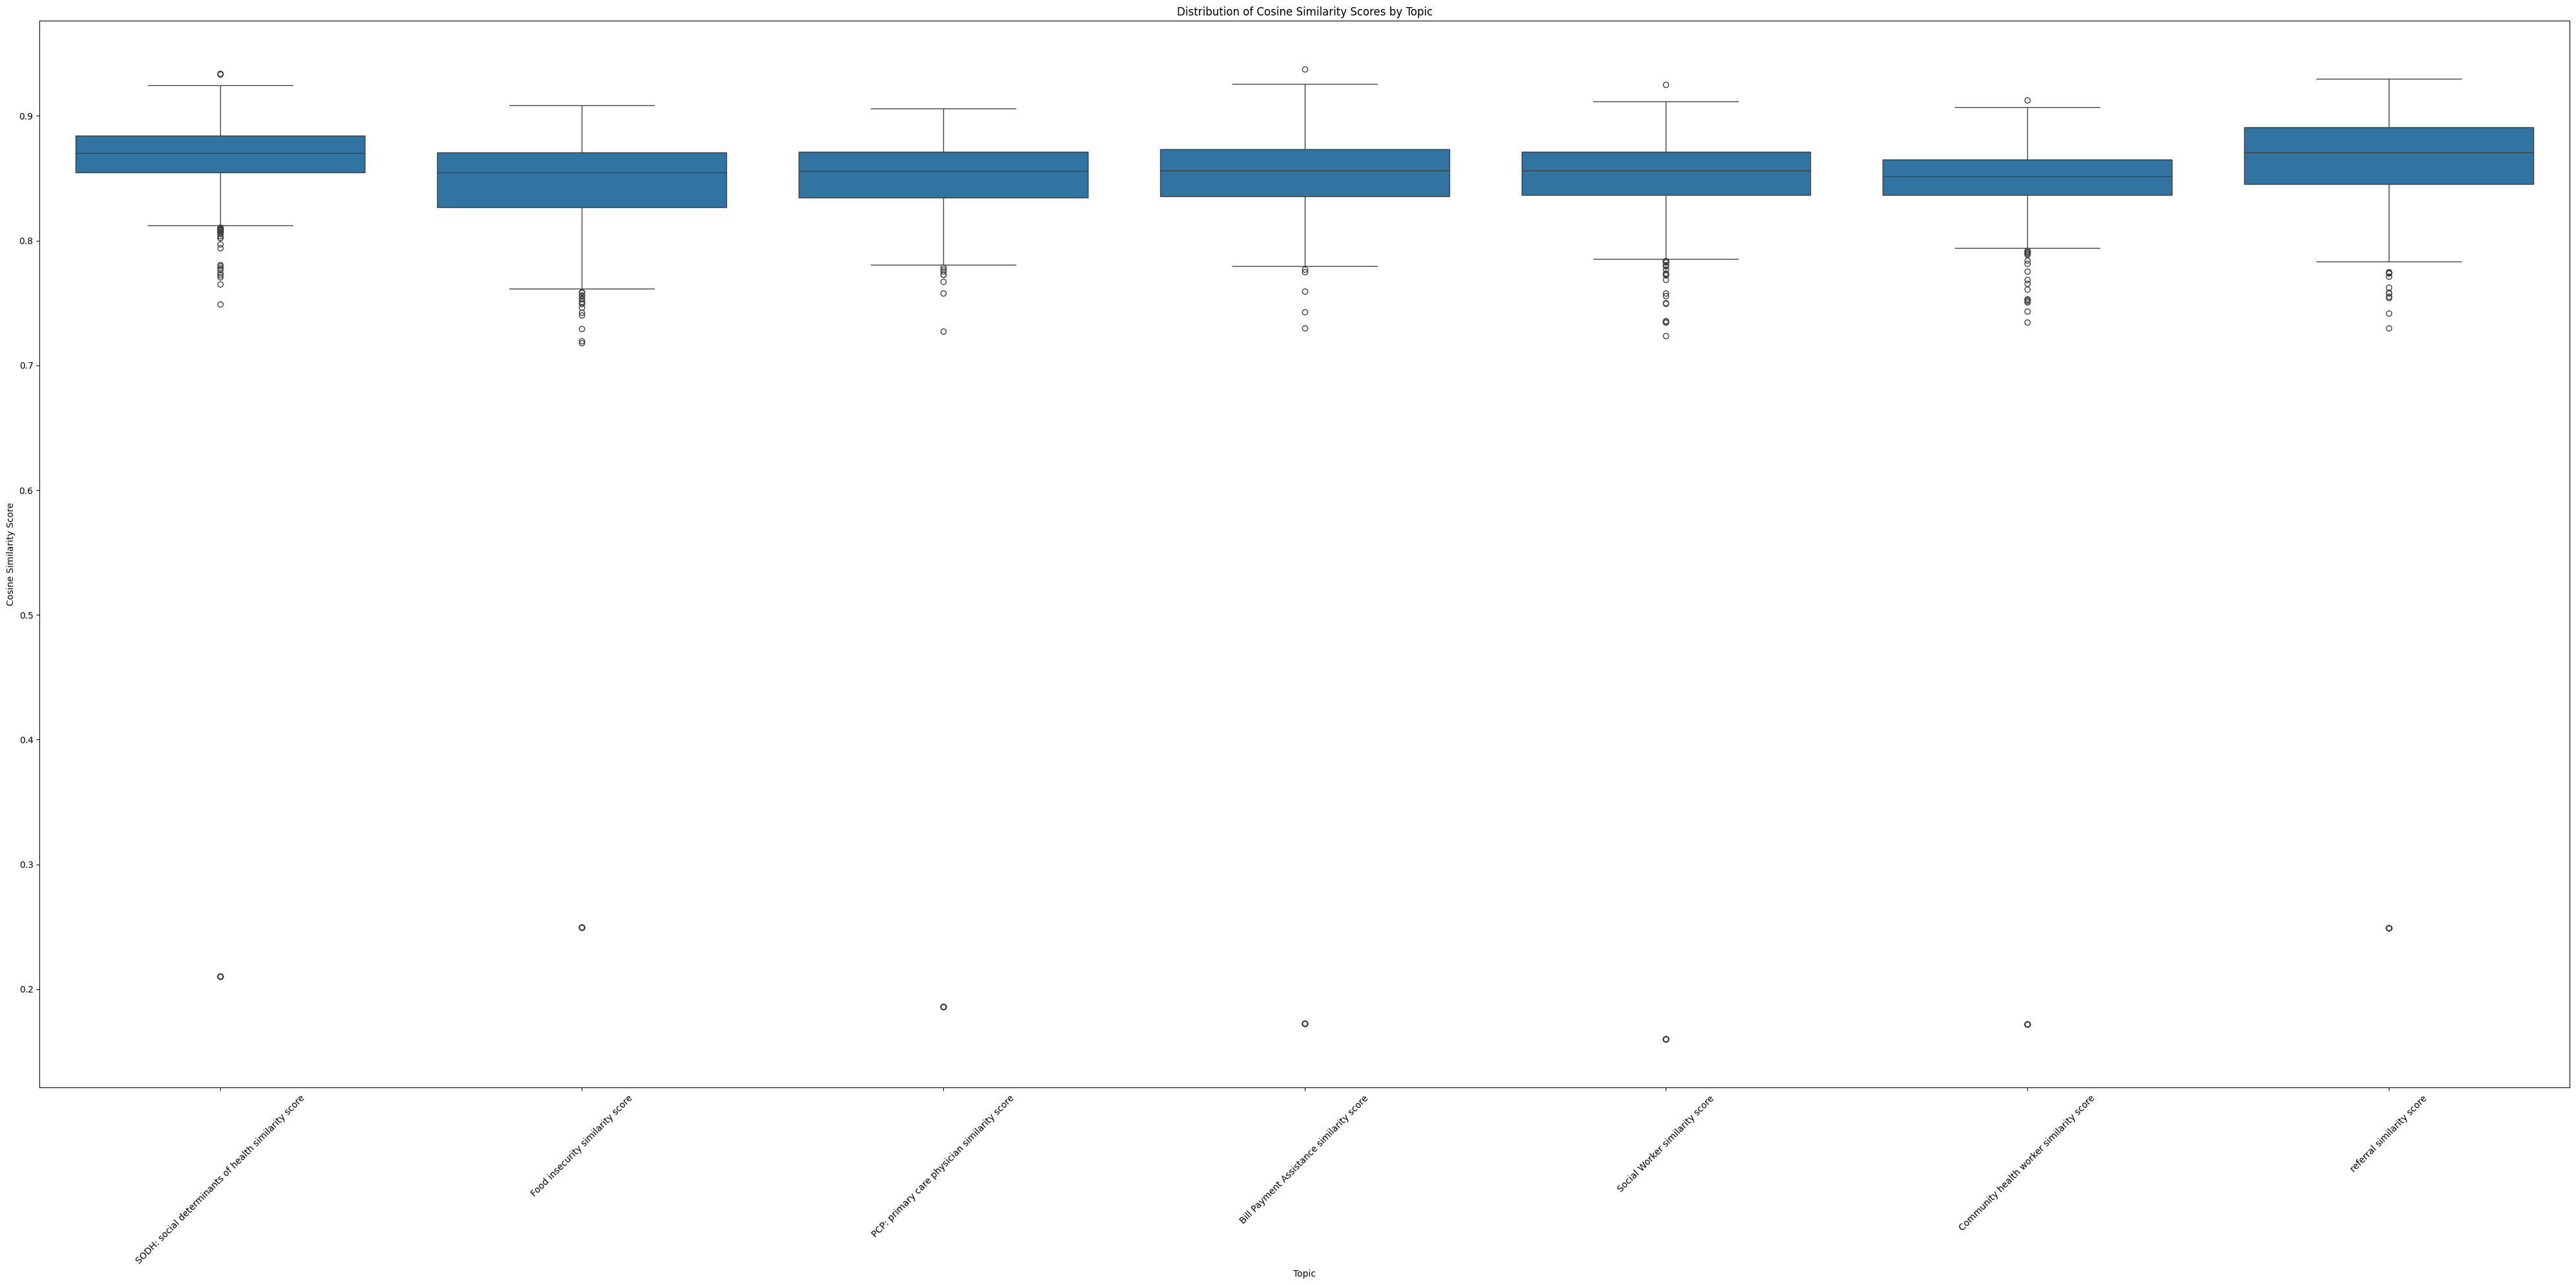

In [ ]:
# Convert all columns to numeric, coercing errors to NaN
suhi_filtered_without_null_with_extraction_df[similarity_score_columns] = suhi_filtered_without_null_with_extraction_df[similarity_score_columns].apply(pd.to_numeric, errors='coerce')

# Reshape the DataFrame to have 'topic' and 'cosine_similarity' columns
df_melted = suhi_filtered_without_null_with_extraction_df[similarity_score_columns].melt(var_name='topic', value_name='cosine_similarity')

# 1. Calculate summary statistics for each topic
topic_stats = df_melted.groupby('topic')['cosine_similarity'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()

# 2. Create a box plot to visualize the distribution of scores across topics
plt.figure(figsize=(40, 20))
sns.boxplot(x='topic', y='cosine_similarity', data=df_melted)
plt.title('Distribution of Cosine Similarity Scores by Topic')
plt.xlabel('Topic')
plt.ylabel('Cosine Similarity Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


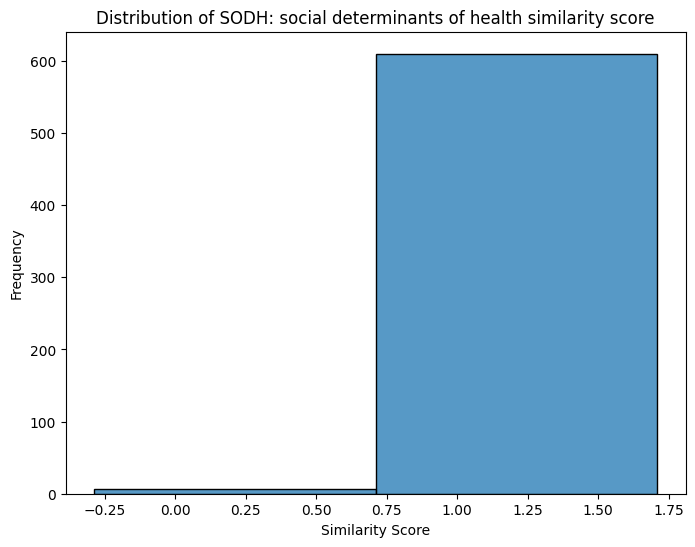

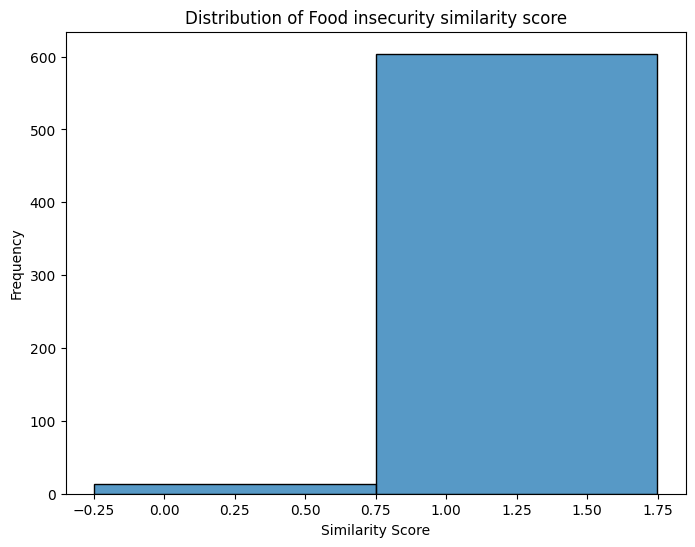

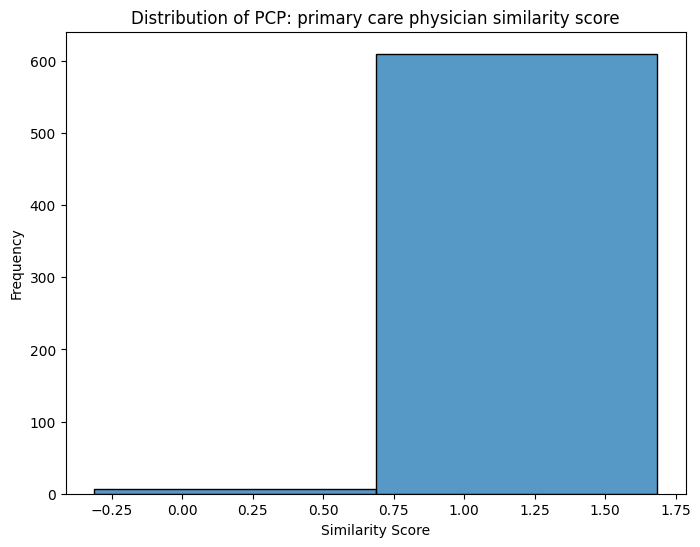

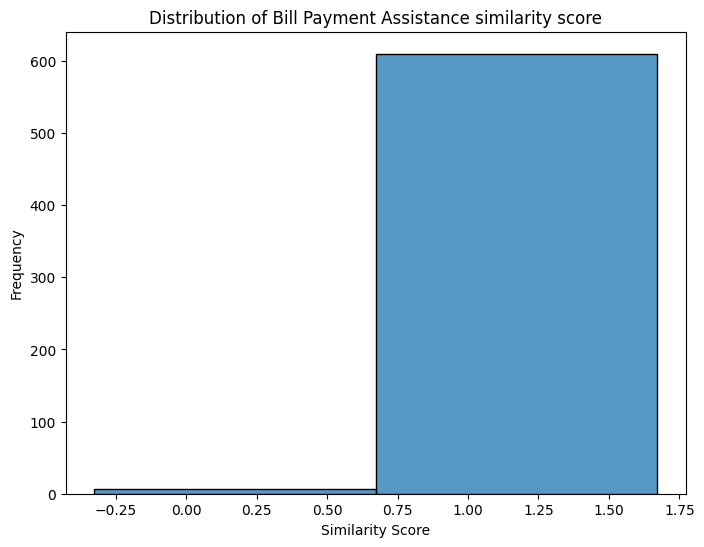

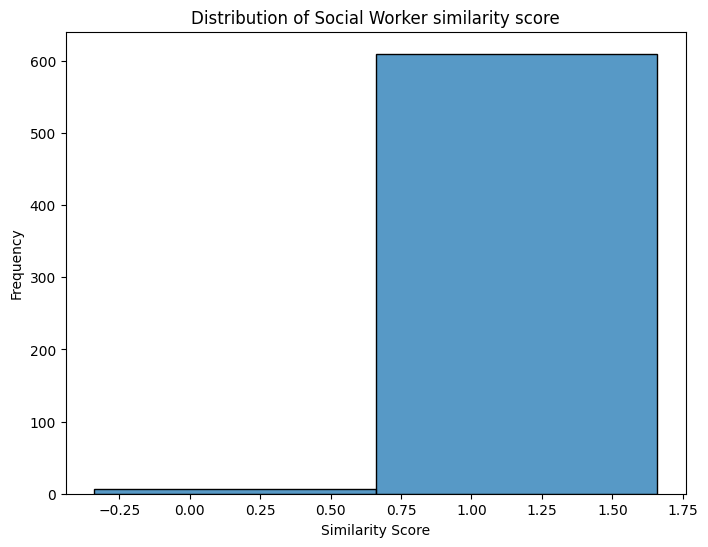

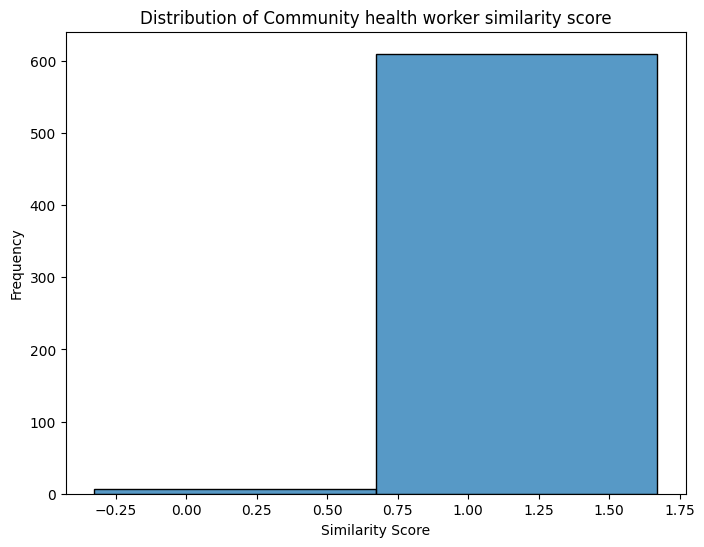

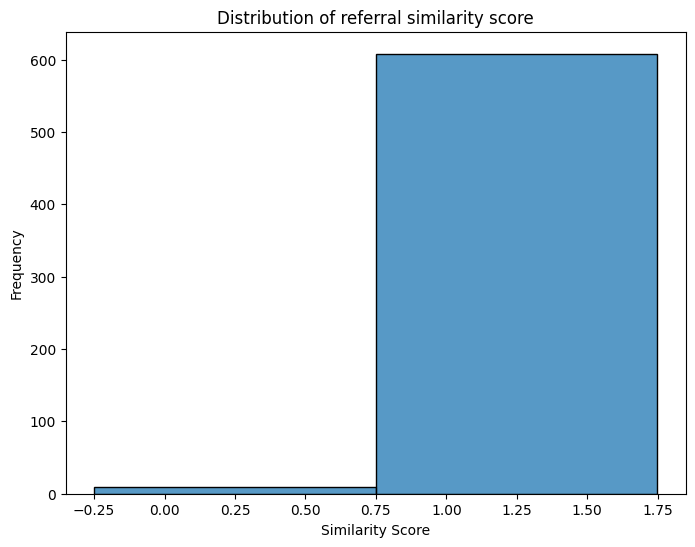

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
for column in suhi_filtered_without_null_with_extraction_df.columns:
  if 'similarity score' in column:
    # Visualize the distribution of scores for similarity score columns
    plt.figure(figsize=(8, 6))
    sns.histplot(suhi_filtered_without_null_with_extraction_df[column], bins=40)
    plt.title(f'Distribution of {column}')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')